# Neumann analytical solution for the classical Stephan problem - Water freezing

    - Authors: Niccolò Tubini, Stephan Gruber, Riccardo Rigon
    - Licence: this work is licensed under a Creative Commons Attribution-NonCommercial 4.0 International License
---
This notebook presents the comparison between the Neumann analytical solution for water freezing and the numerical solution obtained with FreThaw1D. FreThaw1D is a 1D semi-implicit finite volume solver for the enthalpy - or conservative - form of the heat equation. FreThaw1D implements the nested Newton-Casulli-Zanolli algorithm to linearize the nonlinear system of equation resulting from the numerical approximation of the govering equation.

The time step integration is $3600$ [s] and three different grid spacing are used $0.001$ [m], $0.005$ [m], $0.01$ [m].


In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import rc
%matplotlib inline
import matplotlib.style as style 
import math
import xarray as xr
from my_plot import set_size

import warnings
warnings.filterwarnings('ignore')

style.available
style.use('seaborn-whitegrid')

nice_fonts = {
        "legend.frameon": True,
        "legend.fancybox": True,
        "legend.facecolor": "white",
        "axes.edgecolor": "0.8",
        "axes.linewidth": 0.6,
        "grid.linewidth":0.4,
        # Use LaTeX to write all text
        "text.usetex": True,
        "font.family": "serif",
        # Use 10pt font in plots, to match 10pt font in document
        "axes.labelsize": 14,
        "font.size": 14,
        # Make the legend/label fonts a little smaller
        "legend.fontsize": 12,
        "xtick.labelsize": 12,
        "ytick.labelsize": 12,
}

plt.rcParams.update(nice_fonts)

oms_project_path = os.path.dirname(os.getcwd())
plot_folder = (oms_project_path+'/plots/NestedNewtonPaper')

C:\Users\Niccolo\Anaconda3\envs\geoframe_vicenza\lib\site-packages\xarray\core\merge.py:17: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


In [2]:
oms_project_path

'C:\\Users\\Niccolo\\OMS\\OMS_Project_FreThaw1D'

## Parameters for the analytical solution

In [3]:
l_f = 333700

c_w = 4187
lambda_w = 0.6
rho_w = 1000
k_w = lambda_w/(rho_w*c_w)

c_i = 2108
lambda_i = 2.09
rho_i = 970
k_i = lambda_i/(rho_i*c_i)

Tc = 0
TL=-5
TR=5

xL = 0
xR = 10


## Functions to compute the analytical solution

In [4]:
def g_fun(gamma):
    return gamma*np.sqrt(k_i)*l_f*rho_w - lambda_i*(Tc-TL)/math.erf(gamma)*np.exp(-gamma**2)/np.sqrt(np.pi*k_i) - lambda_w*(Tc-TR)/math.erfc(gamma*np.sqrt(k_i/k_w))*np.exp(-gamma**2*k_i/k_w)/np.sqrt(np.pi*k_w)
    

def dg_fun(gamma):
    eps = 1e-7
    return ( g_fun(gamma+eps) - g_fun(gamma-eps) )/(2*eps)

def Newton(gamma0):
    gamma = gamma0
    tol = 1e-12
    for i_newton in range(1,100):
        gk = g_fun(gamma)
        res = abs(gk)
        if (res<tol):
            break
        dgamma = -gk/dg_fun(gamma)
        gamma = gamma + dgamma
        
    return gamma

gamma = Newton(1)

def Neumann_temperature(x, dt, gamma, xL, xR, TL, TR, TMAX, k_i, k_w):
    '''
    Function to compute the solution of the temperature field
    and the position of the freezing front (zero-isotherm)
    
    return: T the temperature field (time, x)
    return: zero_isotherm position (time)
    '''
    Te = np.zeros((TMAX,len(x)))
    zero_isotherm = np.zeros(TMAX)
    
    G1 = (Tc-TL)/math.erf(gamma)
    G2 = (Tc-TR)/math.erfc(gamma*np.sqrt(k_i/k_w))
    
    for t in range(0,TMAX):
        
        time = 0 + dt*(t+1)
        s = gamma*2*np.sqrt(k_i*time)
        
        zero_isotherm[t] = s
        
        for i in range(0,len(x)):
            if ((xR-x[i])<s):
                Te[t,i] = TL + G1*math.erf((xR-x[i])/2/np.sqrt(k_i*time))
            else:
                Te[t,i] = TR + G2*math.erfc((xR-x[i])/2/np.sqrt(k_w*time))
                
    return [Te, zero_isotherm]

In [5]:
def zero_isotherm(time, T, z):
    '''
    Compute the zero-isotherm of the numerical solution.
    The zero-isotherm is computes as linear intepolation of the temperature
    field.
    
    return: zero_isotherm
    '''
    zero_isotherm = np.zeros(len(time))
    
    for t in range(0,len(time)):
    
        for k in range(0,len(z)):
            if T[t,k]<=273.15:
                m =  (T[t,k]-T[t,k-1])/(z[k]-z[k-1])
                q = T[t,k]  - m*z[k] 
                zero_isotherm[t] = (273.15 - T[t,k] + m*z[k])/m
                break
            else:
                zero_isotherm[t] = np.nan
    
    return zero_isotherm

In [6]:
os.chdir(oms_project_path + '/output')
# os.listdir()

In [7]:
with xr.open_dataset('NeumannAnalytical_Freezing_dz001_3600s.nc', engine='scipy') as ds_dz001:
    print('read')
with xr.open_dataset('NeumannAnalytical_Freezing_dz005_3600s.nc', engine='scipy') as ds_dz005:
    print('read')
with xr.open_dataset('NeumannAnalytical_Freezing_dz01_3600s.nc', engine='scipy') as ds_dz01:
    print('read')

read
read
read


In [8]:
[T_analytical, zero_isotherm_analytical] = Neumann_temperature(ds_dz001.z.values[:], 3600, gamma, xL, xR, TL, TR, len(ds_dz001.time.values), k_i, k_w)
ds_dz001["TAnalytical"]=(['time','z'], T_analytical)
ds_dz001["zeroIsothermAnalytical"]=(['time'], zero_isotherm_analytical)

[T_analytical, zero_isotherm_analytical] = Neumann_temperature(ds_dz005.z.values[:], 3600, gamma, xL, xR, TL, TR, len(ds_dz005.time.values), k_i, k_w)
ds_dz005["TAnalytical"]=(['time','z'], T_analytical)
ds_dz005["zeroIsothermAnalytical"]=(['time'], zero_isotherm_analytical)

[T_analytical, zero_isotherm_analytical]  = Neumann_temperature(ds_dz01.z.values[:] , 3600, gamma, xL, xR, TL, TR, len(ds_dz01.time.values), k_i, k_w)
ds_dz01["TAnalytical"]=(['time','z'], T_analytical)
ds_dz01["zeroIsothermAnalytical"]=(['time'], zero_isotherm_analytical)

num_freezing_front = zero_isotherm(ds_dz001.time.values, ds_dz001.T.values, ds_dz001.z.values[:])
ds_dz001["zeroIsotherm"]=(['time'], num_freezing_front)

num_freezing_front = zero_isotherm(ds_dz005.time.values, ds_dz005.T.values, ds_dz005.z.values[:])
ds_dz005["zeroIsotherm"]=(['time'], num_freezing_front)

num_freezing_front = zero_isotherm(ds_dz01.time.values, ds_dz01.T.values, ds_dz01.z.values[:])
ds_dz01["zeroIsotherm"]=(['time'], num_freezing_front)



## Freezing front position: comparison between the analytical solution and the numerical solution

In [9]:
page_width = 500.0 #pt

plot_width = set_size(page_width, subplots=(1, 1))[0]

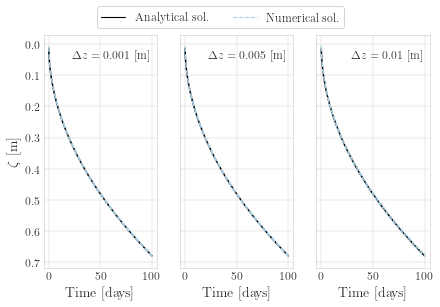

In [10]:
start_date = '2000-01-01'
end_date = '2000-04-10 00:00'
line_w = 1.5 #0.7
line_s_a = '-'
line_s_num = '--'
color_a = 'black'
color_num = 'red'
color_num_1 = '#a6cee3'


fig, ax = plt.subplots(1, 3, sharey='row', figsize=(plot_width,plot_width/1.618))


ax[0].plot(ds_dz001.zeroIsothermAnalytical.sel(time=slice(start_date,end_date)), linestyle=line_s_a  , linewidth=line_w, color= color_a) 
ax[0].plot(10-ds_dz001.zeroIsotherm.sel(time=slice(start_date,end_date))       , linestyle=line_s_num, linewidth=line_w, color= color_num_1)
ax[0].plot(np.nan,np.nan, color='k', linestyle='-', linewidth = 1.1, label='Analytical sol.')
ax[0].plot(np.nan,np.nan, color=color_num_1, linestyle='--', linewidth = 1.1, label='Numerical sol.')

ax[0].set_ylabel('$\\zeta$ [m]')
# to have a x-axis with number of days and not dates
time_step_number = len(ds_dz001.zeroIsothermAnalytical.sel(time=slice(start_date,end_date)))
ax[0].set_xticks([0, time_step_number/2, time_step_number])
ax[0].set_xticklabels(['$0$', '$50$', '$100$' ])
ax[0].set_xlabel('Time [days]')
ax[0].invert_yaxis()


ax[1].plot(ds_dz005.zeroIsothermAnalytical.sel(time=slice(start_date,end_date)), linestyle=line_s_a  , linewidth=line_w, color= color_a) 
ax[1].plot(10-ds_dz001.zeroIsotherm.sel(time=slice(start_date,end_date))       , linestyle=line_s_num, linewidth=line_w, color= color_num_1)
# to have a x-axis with number of days and not dates
ax[1].set_xticks([0, time_step_number/2, time_step_number])
ax[1].set_xticklabels(['$0$', '$50$', '$100$' ])
ax[1].set_xlabel('Time [days]')
                             

ax[2].plot(ds_dz01.zeroIsothermAnalytical.sel(time=slice(start_date,end_date)), linestyle=line_s_a  , linewidth=line_w, color= color_a) 
ax[2].plot(10-ds_dz01.zeroIsotherm.sel(time=slice(start_date,end_date))       , linestyle=line_s_num, linewidth=line_w, color= color_num_1)
# to have a x-axis with number of days and not dates
ax[2].set_xticks([0, time_step_number/2, time_step_number])
ax[2].set_xticklabels(['$0$', '$50$', '$100$' ])
ax[2].set_xlabel('Time [days]')

lgd = ax[0].legend(bbox_to_anchor=(2.7,1.15),ncol=2)

plt.text( 0.25,0.9, '$\Delta z = 0.001$ [m]', fontsize=12,
             transform=ax[0].transAxes)
plt.text( 0.25,0.9, '$\Delta z = 0.005$ [m]', fontsize=12,
             transform=ax[1].transAxes)
plt.text( 0.31,0.9, '$\Delta z = 0.01$ [m]', fontsize=12,
             transform=ax[2].transAxes)

plt.show()


## Temperature at different depths: comparison between the analytical solution and the numerical solution

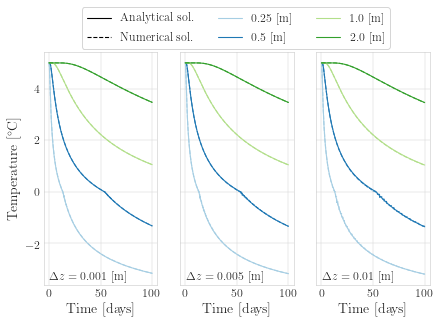

In [11]:

line_w_a = 1.1
line_w_num = 1.1
line_s_a = '-'
line_s_num = '--'
color_a = 'black'
color_num = 'red'
color_num_1 = '#a6cee3'
color_num_2 = '#1f78b4'
color_num_3 = '#b2df8a'
color_num_4 = '#33a02c'

fig, ax = plt.subplots(1, 3, sharey='row', figsize=(plot_width, plot_width/1.618))

ax[0].plot(np.nan,np.nan, color='k', linestyle='-', linewidth = 1.1, label='Analytical sol.')
ax[0].plot(np.nan,np.nan, color='k', linestyle='--', linewidth = 1.1, label='Numerical sol.')

z_to_plot = 10.0-0.25
ax[0].plot(ds_dz001.TAnalytical.sel(z=z_to_plot, method="nearest").sel(time=slice(start_date,end_date)),  linestyle=line_s_a, linewidth=line_w_a, color= color_num_1,label='$0.25$ [m]') 
ax[0].plot(ds_dz001.T.sel(z=z_to_plot, method="nearest").sel(time=slice(start_date,end_date))-273.15   , linestyle=line_s_num, linewidth=line_w_num, color= color_num_1)

z_to_plot = 10.0-0.5
ax[0].plot(ds_dz001.TAnalytical.sel(z=z_to_plot, method="nearest").sel(time=slice(start_date,end_date)), linestyle=line_s_a, linewidth=line_w_a, color= color_num_2,label='$0.5$ [m]') 
ax[0].plot(ds_dz001.T.sel(z=z_to_plot, method="nearest").sel(time=slice(start_date,end_date))-273.15   , linestyle=line_s_num, linewidth=line_w_num, color= color_num_2)

z_to_plot = 10.0-1.0
ax[0].plot(ds_dz001.TAnalytical.sel(z=z_to_plot, method="nearest").sel(time=slice(start_date,end_date)), linestyle=line_s_a, linewidth=line_w_a, color= color_num_3, label='$1.0$ [m]')
ax[0].plot(ds_dz001.T.sel(z=z_to_plot, method="nearest").sel(time=slice(start_date,end_date))-273.15   , linestyle=line_s_num, linewidth=line_w_num, color= color_num_3)

z_to_plot = 10.0-2.0
ax[0].plot(ds_dz001.TAnalytical.sel(z=z_to_plot, method="nearest").sel(time=slice(start_date,end_date)), linestyle=line_s_a, linewidth=line_w_a, color= color_num_4, label='$2.0$ [m]')
ax[0].plot(ds_dz001.T.sel(z=z_to_plot, method="nearest").sel(time=slice(start_date,end_date))-273.15   , linestyle=line_s_num, linewidth=line_w_num, color= color_num_4)

ax[0].set_ylabel('Temperature [$^\circ$C]')
# to have a x-axis with number of days and not dates
time_step_number = len(ds_dz001.time.sel(time=slice(start_date,end_date)))
ax[0].set_xticks([0, time_step_number/2, time_step_number])
ax[0].set_xticklabels(['$0$', '$50$', '$100$' ])
ax[0].set_xlabel('Time [days]')



z_to_plot = 10-0.25
ax[1].plot(ds_dz005.TAnalytical.sel(z=z_to_plot, method="nearest").sel(time=slice(start_date,end_date)),  linestyle=line_s_a, linewidth=line_w_a, color= color_num_1) 
ax[1].plot(ds_dz005.T.sel(z=z_to_plot, method="nearest").sel(time=slice(start_date,end_date))-273.15   , linestyle=line_s_num, linewidth=line_w_num, color= color_num_1) 

z_to_plot = 10-0.5
ax[1].plot(ds_dz005.TAnalytical.sel(z=z_to_plot, method="nearest").sel(time=slice(start_date,end_date)), linestyle=line_s_a, linewidth=line_w_a, color= color_num_2) 
ax[1].plot(ds_dz005.T.sel(z=z_to_plot, method="nearest").sel(time=slice(start_date,end_date))-273.15   , linestyle=line_s_num, linewidth=line_w_num, color= color_num_2)

z_to_plot = 10-1.0
ax[1].plot(ds_dz005.TAnalytical.sel(z=z_to_plot, method="nearest").sel(time=slice(start_date,end_date)), linestyle=line_s_a, linewidth=line_w_a, color= color_num_3) 
ax[1].plot(ds_dz005.T.sel(z=z_to_plot, method="nearest").sel(time=slice(start_date,end_date))-273.15   , linestyle=line_s_num, linewidth=line_w_num, color= color_num_3)

z_to_plot = 10-2.0
ax[1].plot(ds_dz005.TAnalytical.sel(z=z_to_plot, method="nearest").sel(time=slice(start_date,end_date)), linestyle=line_s_a, linewidth=line_w_a, color= color_num_4)
ax[1].plot(ds_dz005.T.sel(z=z_to_plot, method="nearest").sel(time=slice(start_date,end_date))-273.15   , linestyle=line_s_num, linewidth=line_w_num, color= color_num_4)

ax[1].set_xticks([0, time_step_number/2, time_step_number])
ax[1].set_xticklabels(['$0$', '$50$', '$100$' ])
ax[1].set_xlabel('Time [days]')



z_to_plot = 10.0-0.25
ax[2].plot(ds_dz01.TAnalytical.sel(z=z_to_plot, method="nearest").sel(time=slice(start_date,end_date)),  linestyle=line_s_a, linewidth=line_w_a, color= color_num_1) 
ax[2].plot(ds_dz01.T.sel(z=z_to_plot, method="nearest").sel(time=slice(start_date,end_date))-273.15   , linestyle=line_s_num, linewidth=line_w_num, color= color_num_1) 

z_to_plot = 10.0-0.5
ax[2].plot(ds_dz01.TAnalytical.sel(z=z_to_plot, method="nearest").sel(time=slice(start_date,end_date)), linestyle=line_s_a, linewidth=line_w_a, color= color_num_2) 
ax[2].plot(ds_dz01.T.sel(z=z_to_plot, method="nearest").sel(time=slice(start_date,end_date))-273.15   , linestyle=line_s_num, linewidth=line_w_num, color= color_num_2)

z_to_plot = 10.0-1.0
ax[2].plot(ds_dz01.TAnalytical.sel(z=z_to_plot, method="nearest").sel(time=slice(start_date,end_date)), linestyle=line_s_a, linewidth=line_w_a, color= color_num_3)
ax[2].plot(ds_dz01.T.sel(z=z_to_plot, method="nearest").sel(time=slice(start_date,end_date))-273.15   , linestyle=line_s_num, linewidth=line_w_num, color= color_num_3)

z_to_plot = 10.0-2.0
ax[2].plot(ds_dz01.TAnalytical.sel(z=z_to_plot, method="nearest").sel(time=slice(start_date,end_date)), linestyle=line_s_a, linewidth=line_w_a, color= color_num_4)
ax[2].plot(ds_dz01.T.sel(z=z_to_plot, method="nearest").sel(time=slice(start_date,end_date))-273.15   , linestyle=line_s_num, linewidth=line_w_num, color= color_num_4)

ax[2].set_xticks([0, time_step_number/2, time_step_number])
ax[2].set_xticklabels(['$0$', '$50$', '$100$' ])
ax[2].set_xlabel('Time [days]')


lgd = ax[0].legend(bbox_to_anchor=(3.1,1.22), ncol=3)

plt.text( 0.05,0.02, '$\Delta z = 0.001$ [m]', fontsize=12,
             transform=ax[0].transAxes)
plt.text( 0.05,0.02, '$\Delta z = 0.005$ [m]', fontsize=12,
             transform=ax[1].transAxes)
plt.text( 0.05,0.02, '$\Delta z = 0.01$ [m]', fontsize=12,
             transform=ax[2].transAxes)

plt.show()
